# Highest Grossing Writers and Directors

What data sets?
- tn movie budgets
- IMDB title crew, IMDB name basics, IMDB title basics

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandasql import sqldf

IMDB name basics, provides writer and director names

In [3]:
#From Erica's data cleaning
imdb_name_df = pd.read_csv('zippedData/imdb.name.basics.csv.gz', compression='gzip')
imdb_name_df = imdb_name_df.drop(columns=['birth_year', 'death_year']) #Both of these columns are missing ~85%+ values 

imdb_name_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 4 columns):
nconst                606648 non-null object
primary_name          606648 non-null object
primary_profession    555308 non-null object
known_for_titles      576444 non-null object
dtypes: object(4)
memory usage: 18.5+ MB


Import combined/cleaned data set with includes TN budget/gross data, and IMDB movie name, movie ID, directory and writer IDs

In [15]:
df = pd.read_csv('TN_budget_and_IMDB.csv').drop_duplicates('tconst')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 3839
Data columns (total 8 columns):
movie                3625 non-null object
genres               3625 non-null object
directors            3625 non-null object
writers              3625 non-null object
production_budget    3625 non-null int64
domestic_gross       3625 non-null int64
worldwide_gross      3625 non-null int64
tconst               3625 non-null object
dtypes: int64(3), object(5)
memory usage: 254.9+ KB


In [17]:
df.head(10)

,movie,genres,directors,writers,production_budget,domestic_gross,worldwide_gross,tconst
0,Foodfight!,"Action,Animation,Comedy",nm0440415,"nm0440415,nm0923312,nm0295165,nm0841854,nm0220297",45000000,0,73706,tt0249516
1,Mortal Kombat,"Action,Adventure,Fantasy",nm2585406,nm3859643,20000000,70433227,122133227,tt0293429
2,The Overnight,Genre Data Missing,nm1208371,"nm1170333,nm1208371",200000,1109808,1165996,tt0326592
3,On the Road,"Adventure,Drama,Romance",nm0758574,"nm0449616,nm1433580",25000000,720828,9313302,tt0337692
4,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",nm0001774,"nm0175726,nm0862122",91000000,58236838,187861183,tt0359950
5,A Walk Among the Tombstones,"Action,Crime,Drama",nm0291082,"nm0088747,nm0291082",28000000,26017685,62108587,tt0365907
6,Jurassic World,"Action,Adventure,Sci-Fi",nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341",215000000,652270625,1648854864,tt0369610
7,The Rum Diary,"Comedy,Drama",nm0732430,"nm0732430,nm0860219",45000000,13109815,21544732,tt0376136
8,The Three Stooges,"Comedy,Family","nm0268380,nm0268370","nm0148808,nm0268370,nm0268380",30000000,44338224,54052249,tt0383010
9,Anderson's Cross,"Comedy,Drama,Romance",nm1516329,nm1516329,300000,0,0,tt0393049


Next steps: change director/writer ids to names, split cs cells to multiple rows, group by director or writer. Remove rows with no gross income data. Consider mean vs median
- need separate databases for director info and writer info

In [46]:
df['num_writers'] = df['writers'].apply(lambda x:len(x.split(',')))
df['num_directors'] = df['directors'].apply(lambda x:len(x.split(',')))

In [49]:
df['num_writers'].value_counts()

1     1791
2      971
3      451
4      210
5       99
6       42
7       18
9       13
8       13
10       9
11       3
25       1
13       1
20       1
14       1
12       1
Name: num_writers, dtype: int64

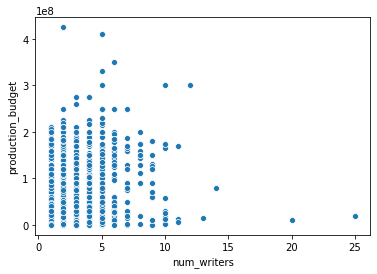

In [50]:
sns.scatterplot(x='num_writers',y='production_budget',data=df)

In [43]:
writer_count = writer_names_df.groupby('primary_name').count()
writer_count.sort_values('movie',ascending=False)

,movie,domestic_gross,worldwide_gross
primary_name,,,
William Shakespeare,22,22,22
Jack Kirby,20,20,20
Stan Lee,19,19,19
Luc Besson,12,12,12
Nicholas Stoller,11,11,11
...,...,...,...
Hideo Oguni,1,1,1
Hilary Winston,1,1,1
Himesh Reshammiya,1,1,1


In [28]:
new_df = pd.DataFrame(df.directors.str.split(',').tolist(), index=df.tconst).stack()
new_df = new_df.reset_index([0, 'tconst'])
new_df.columns = ['tconst','director']


q = """SELECT movie, director, domestic_gross, worldwide_gross
    FROM df
    JOIN new_df
    USING(tconst)
    WHERE (domestic_gross > 0 OR worldwide_gross > 0) AND director != 'Missing director data';"""

directors_df = sqldf(q)
directors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 4 columns):
movie              3682 non-null object
director           3682 non-null object
domestic_gross     3682 non-null int64
worldwide_gross    3682 non-null int64
dtypes: int64(2), object(2)
memory usage: 115.2+ KB


In [27]:
q = """SELECT movie, primary_name, domestic_gross, worldwide_gross
    FROM directors_df d
    JOIN imdb_name_df name
    ON d.director == name.nconst;"""

director_names_df = sqldf(q)
director_names_df

,movie,primary_name,domestic_gross,worldwide_gross
0,Foodfight!,Lawrence Kasanoff,0,73706
1,Mortal Kombat,Simon McQuoid,70433227,122133227
2,The Overnight,Jed I. Goodman,1109808,1165996
3,On the Road,Walter Salles,720828,9313302
4,The Secret Life of Walter Mitty,Ben Stiller,58236838,187861183
...,...,...,...,...
3677,Sisters,Prachya Pinkaew,87044645,106030660
3678,Ali,Ramazan Özer,58183966,87683966
3679,The Promise,Edwine Dorival,8224288,10551417
3680,Columbus,Hatef Alimardani,1017107,1110511


In [35]:
director_names_df[director_names_df['primary_name'] == 'Atsushi Wada']

,movie,primary_name,domestic_gross,worldwide_gross
1062,Avatar,Atsushi Wada,760507625,2776345279


In [39]:
director_count = director_names_df.groupby('primary_name').count()
director_count.sort_values('movie',ascending=False)

,movie,domestic_gross,worldwide_gross
primary_name,,,
Tim Story,8,8,8
Steven Spielberg,8,8,8
Clint Eastwood,7,7,7
Jon M. Chu,6,6,6
Denis Villeneuve,6,6,6
...,...,...,...
Jack O'Donoghue,1,1,1
Jack Spring,1,1,1
Jackie Earle Haley,1,1,1


In [32]:
director_median = director_names_df.groupby('primary_name').median()
dom_gross = director_median.sort_values('domestic_gross',ascending=False).head(5)
dom_gross['domestic_gross'] = dom_gross['domestic_gross'].map(lambda x:x/dom_gross['domestic_gross'].max())
ww_gross = director_median.sort_values('worldwide_gross',ascending=False).head(5)
ww_gross['worldwide_gross'] = ww_gross['worldwide_gross'].map(lambda x:x/ww_gross['domestic_gross'].max())

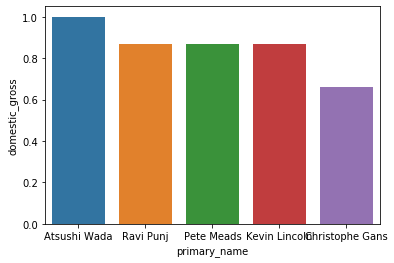

In [33]:
sns.barplot(x = dom_gross.index,y = dom_gross['domestic_gross'])

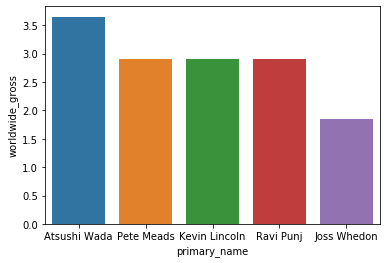

In [34]:
sns.barplot(x = ww_gross.index,y = ww_gross['worldwide_gross'])